# Figure X.x - Supervised model performance

Goals : 

- Show that 3D models outperform usual 2D models

In [15]:
import numpy as np
from tifffile import imread
import sys
import numpy as np

import pyclesperanto_prototype as cle
from stardist.matching import matching_dataset
sys.path.append("../..")

from utils import *
from plots import *
print("Used GPU: ", cle.get_device())
show_params()
#################
SAVE_PLOTS_AS_PNG = False
SAVE_PLOTS_AS_SVG = False

Used GPU:  <NVIDIA GeForce RTX 4070 Ti on Platform: NVIDIA CUDA (2 refs)>
Plot parameters (set in plots.py) : 
- COLORMAP : ██████████
- DPI : 200
- Data path : C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK
- Font size : 15
- Title font size : 26
- Label font size : 18


In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [17]:
data_path = DATA_PATH / "RESULTS/SUPERVISED_PERF_FIG/INFERENCE"
fold1_path = data_path / "fold1"
fold2_path = data_path / "fold2"
fold3_path = data_path / "fold3"

# get all tif in fold folders in which "label" does not appear
def get_fold_data(fold_path):
    return [imread(f) for f in fold_path.glob("*.tif") if "label" not in f.name], [imread(f) for f in fold_path.glob("*.tif") if "label" in f.name]

fold1_image, fold1_GT = get_fold_data(fold1_path)
fold2_image, fold2_GT = get_fold_data(fold2_path)
fold3_image, fold3_GT = get_fold_data(fold3_path)

In [18]:
fold_paths = [fold1_path, fold2_path, fold3_path]

def get_predictions(path):
    return [imread(f) for f in path.glob("*.tif")]
#################
swin_paths = [f / "Swin" for f in fold_paths]
segresnet_paths = [f / "SegResNet" for f in fold_paths]
#################
cellpose_paths = [f / "Cellpose" for f in fold_paths]
stardist_paths = [f / "stardist" for f in fold_paths]

swin_predictions = [get_predictions(p) for p in swin_paths]
segresnet_predictions = [get_predictions(p) for p in segresnet_paths]
cellpose_predictions = [get_predictions(p) for p in cellpose_paths]
stardist_predictions = [get_predictions(p) for p in stardist_paths]

In [19]:
# TEMP
fold_test = 2
swin = swin_predictions[fold_test][0]
segresnet = segresnet_predictions[fold_test][0]
# cellpose = cellpose_predictions[1][0]
stardist = stardist_predictions[fold_test][0]

labels_gt = fold3_GT[0]

## Computations

In [20]:
swin_thresholded = np.where(swin > 0.5, swin, 0)
segresnet_thresholded = np.where(segresnet > 0.45, segresnet, 0)

In [21]:
swin_instance = cle.voronoi_otsu_labeling(swin_thresholded, spot_sigma=0.65, outline_sigma=0.65)
segresnet_instance = cle.voronoi_otsu_labeling(segresnet_thresholded, spot_sigma=0.65, outline_sigma=0.65)
swin_instance = np.array(swin_instance)
segresnet_instance = np.array(segresnet_instance)

In [22]:
# save_folder = data_path / "processed"
# save_folder.mkdir(exist_ok=True, parents=False)
# from tifffile import imwrite
# imwrite(save_folder / "swin_instance.tif", swin_instance)
# imwrite(save_folder / "segresnet_instance.tif", segresnet_instance)

## Plots

Validating on Swin
********************
Validating on SegResNet
********************
Validating on Stardist
********************


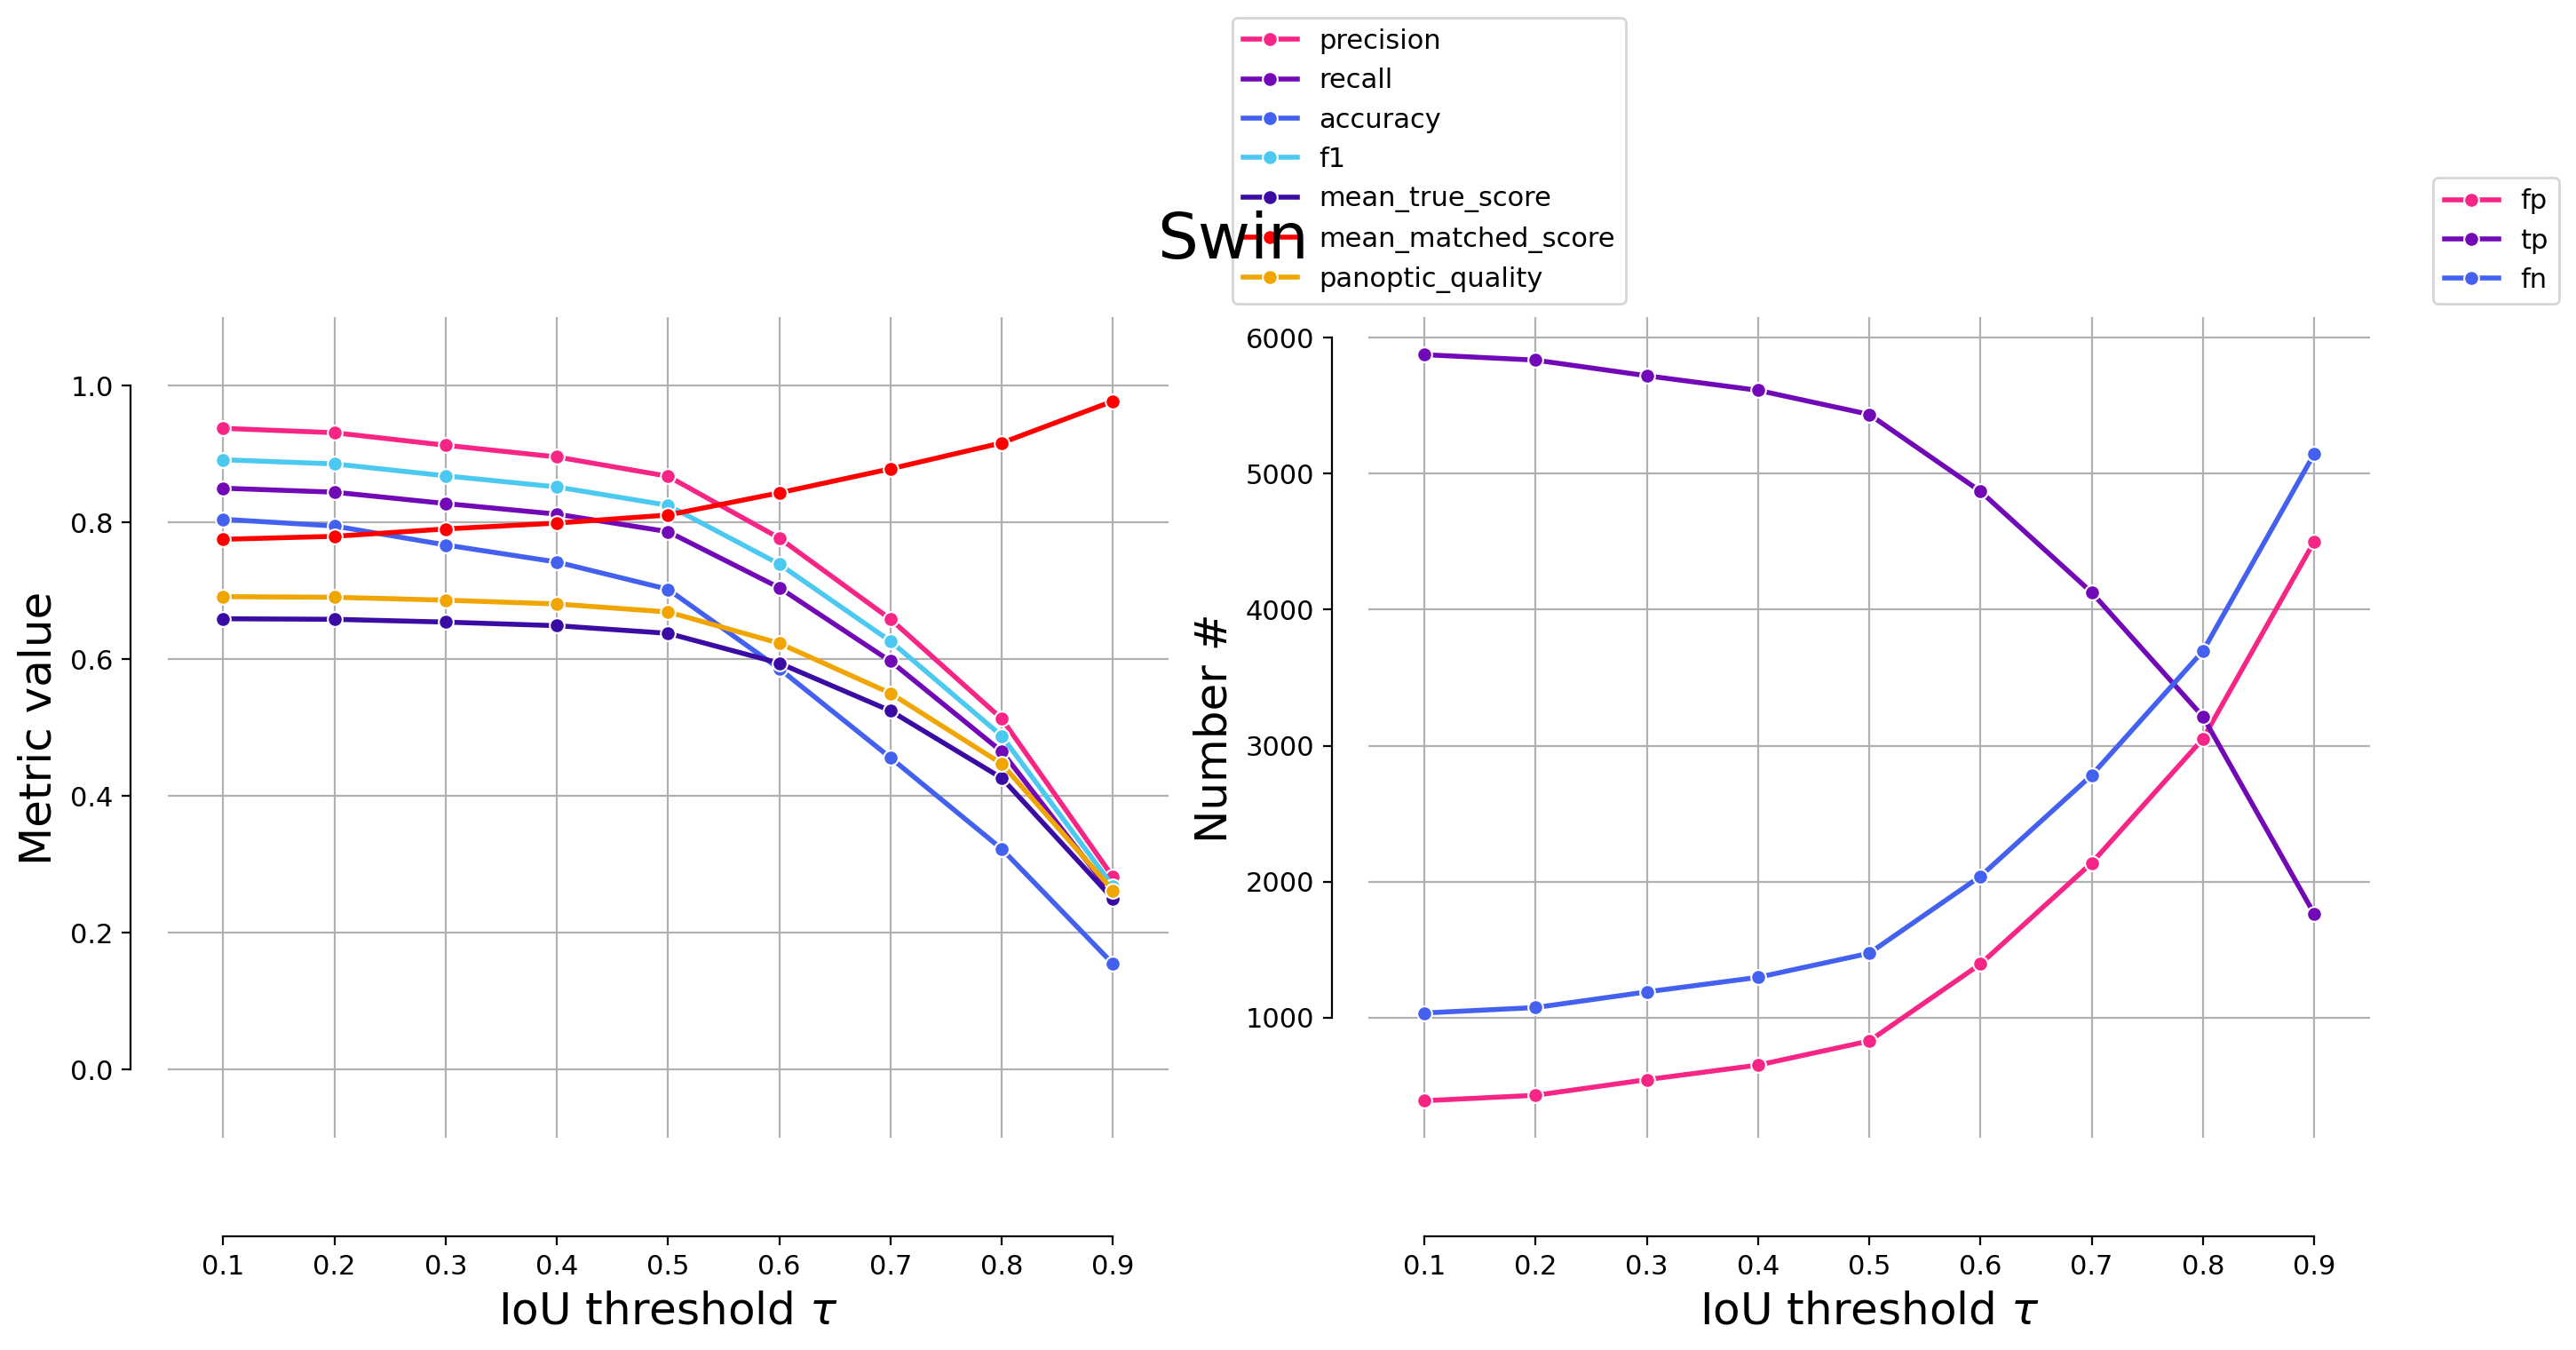

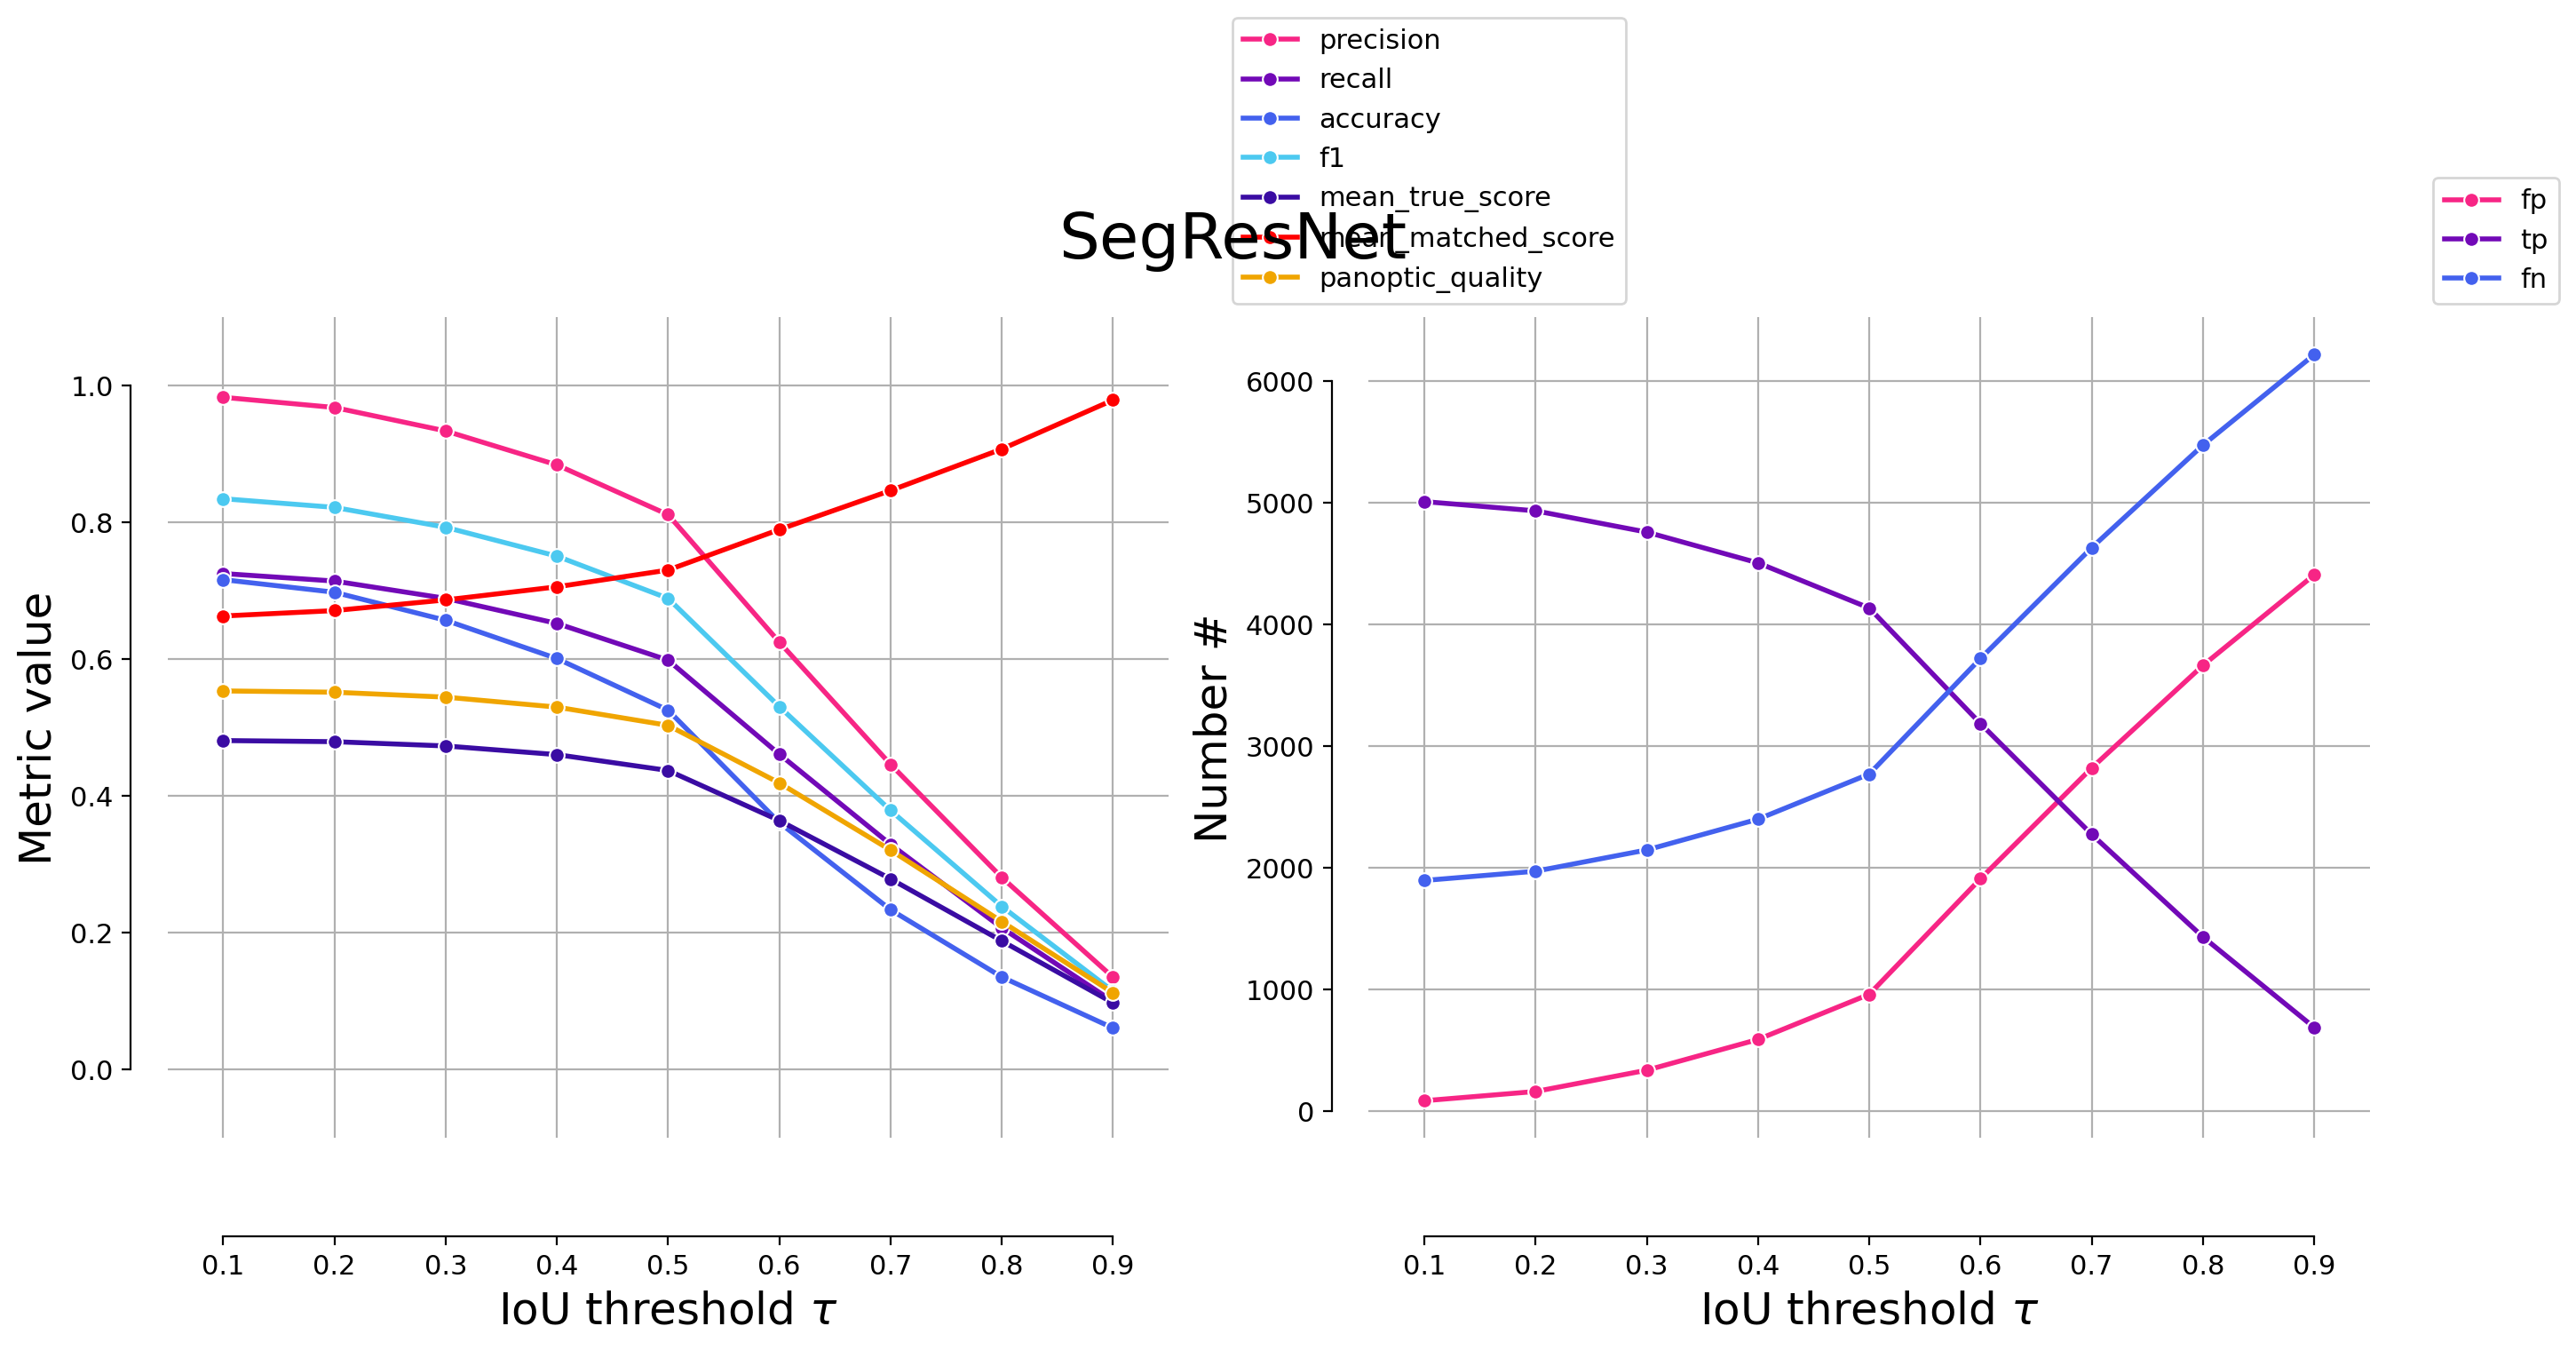

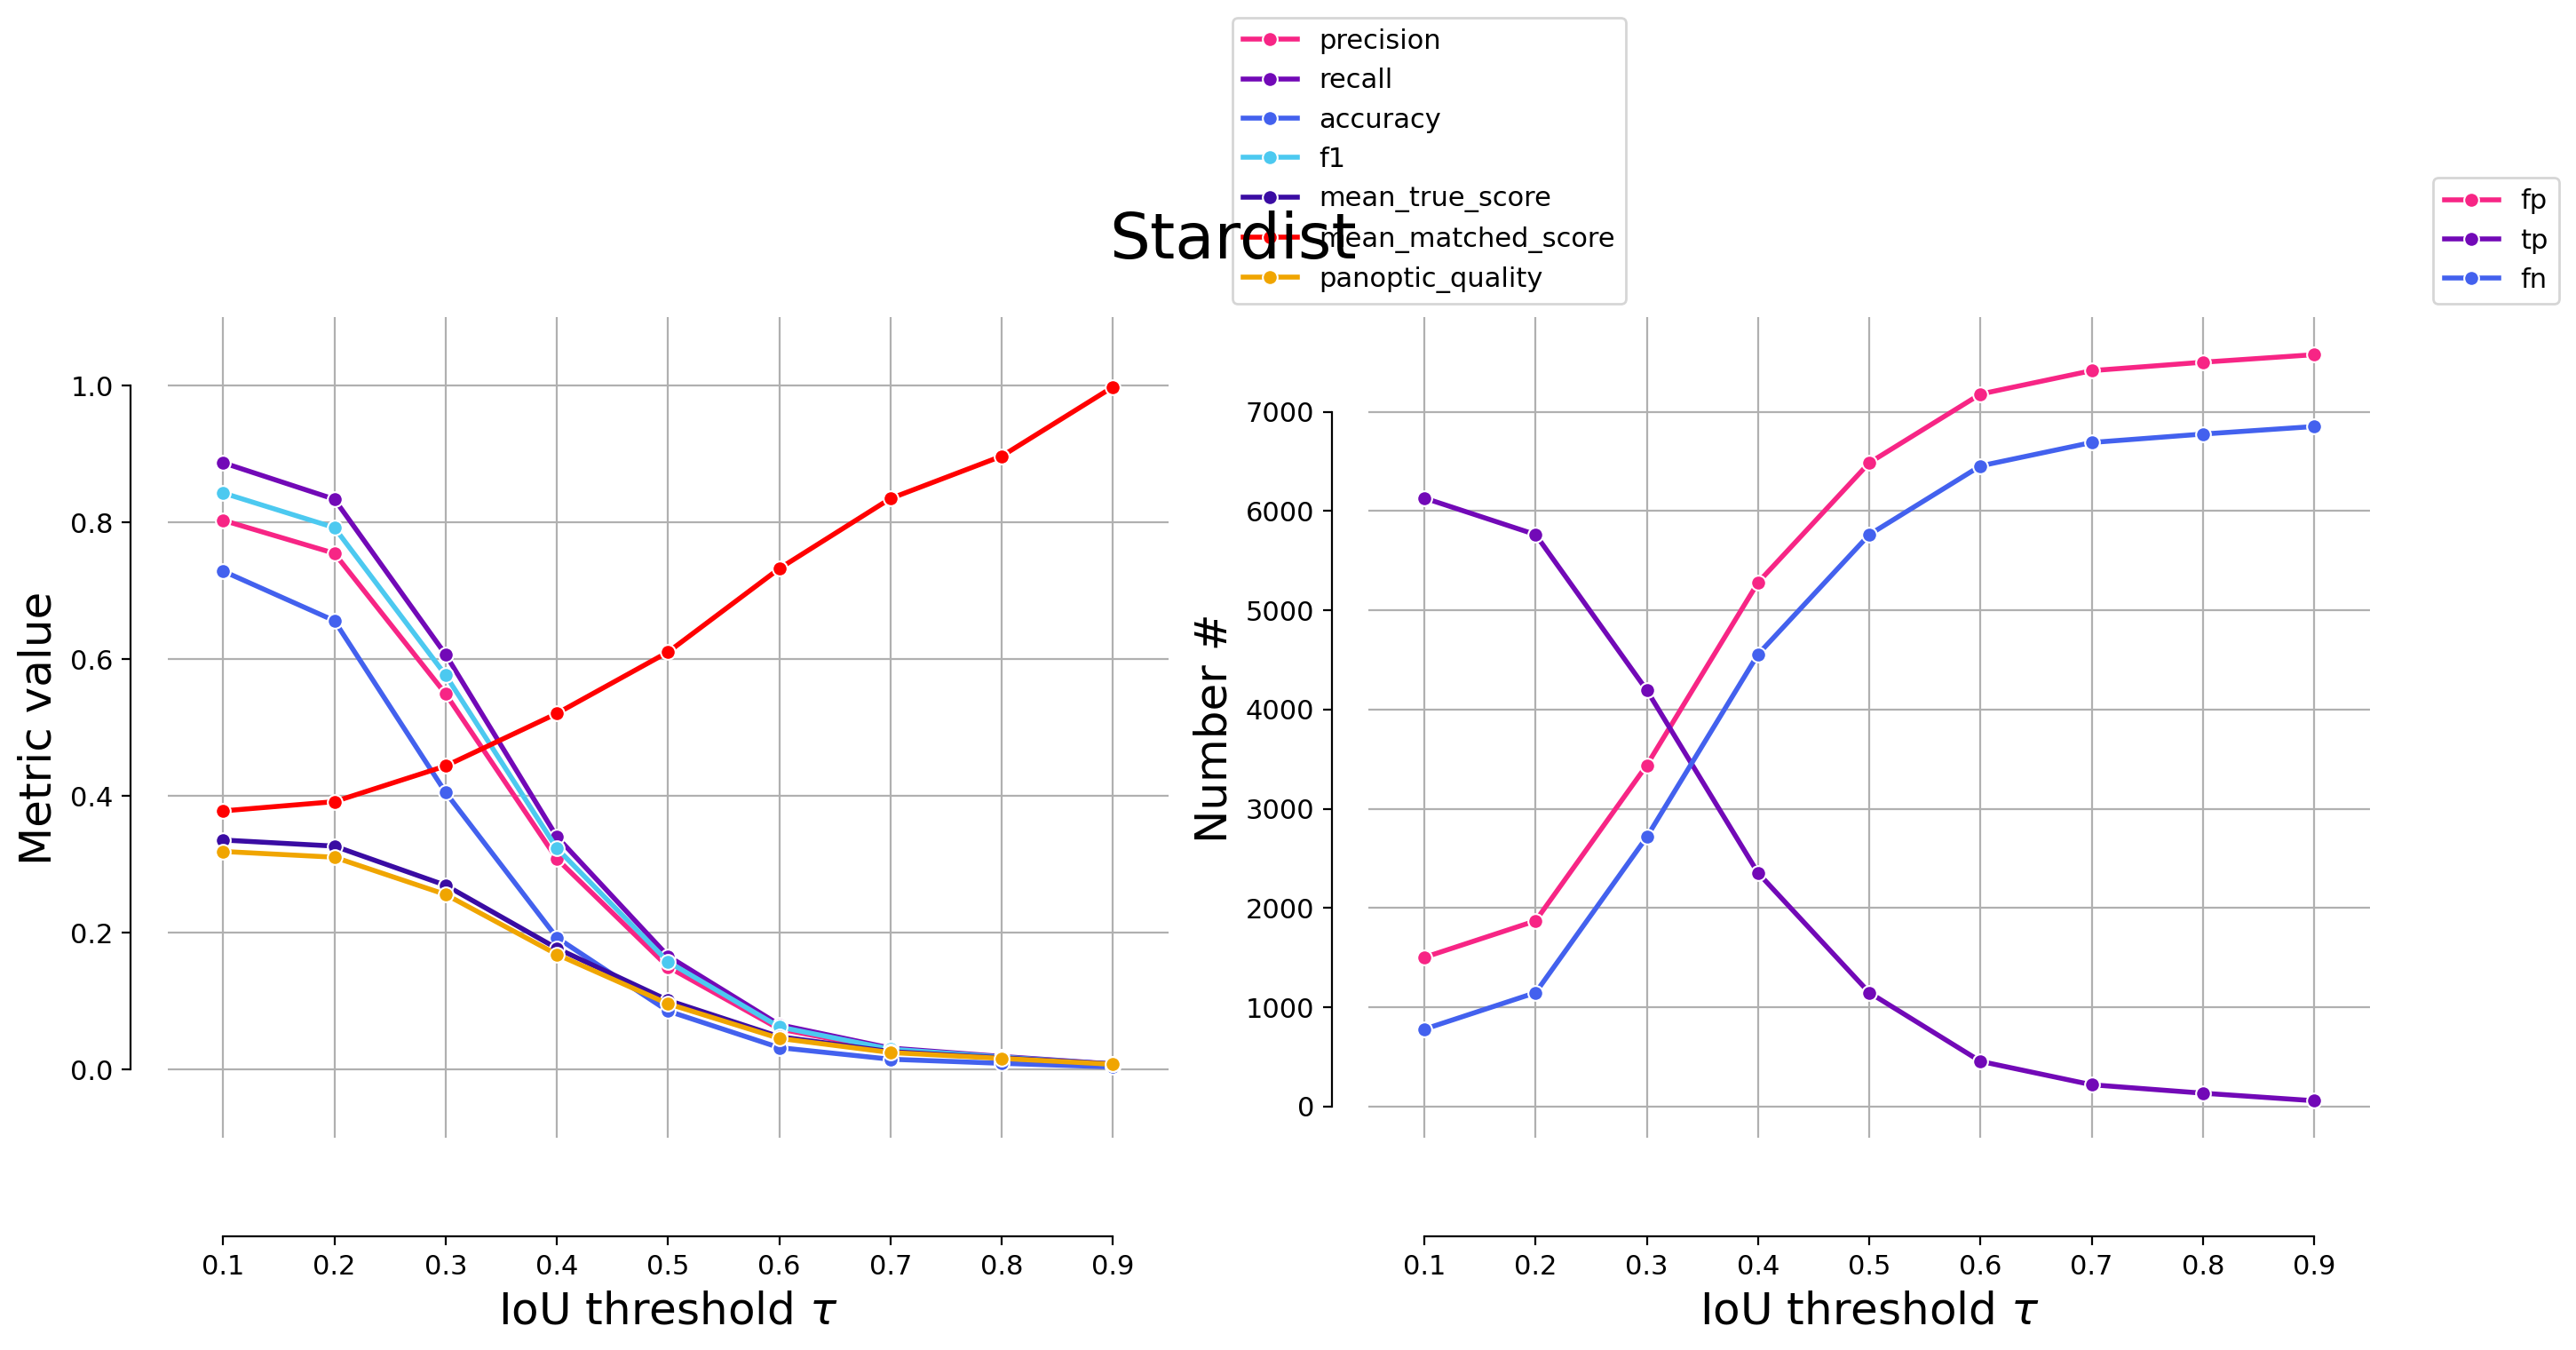

In [23]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predictions = [swin_instance,
               segresnet_instance,
            #    cellpose,
               stardist]
names = ["Swin",
         "SegResNet",
        #  "Cellpose",
         "Stardist"]

model_stats = []
dfs = []

for i, p in enumerate(predictions):
    print(f"Validating on {names[i]}")
    stats = [matching_dataset(
        labels_gt, p, thresh=t, show_progress=False
        ) for t in taus]
    model_stats.append(stats)
    plot_performance(taus, stats, name=names[i])
    print("*"*20)

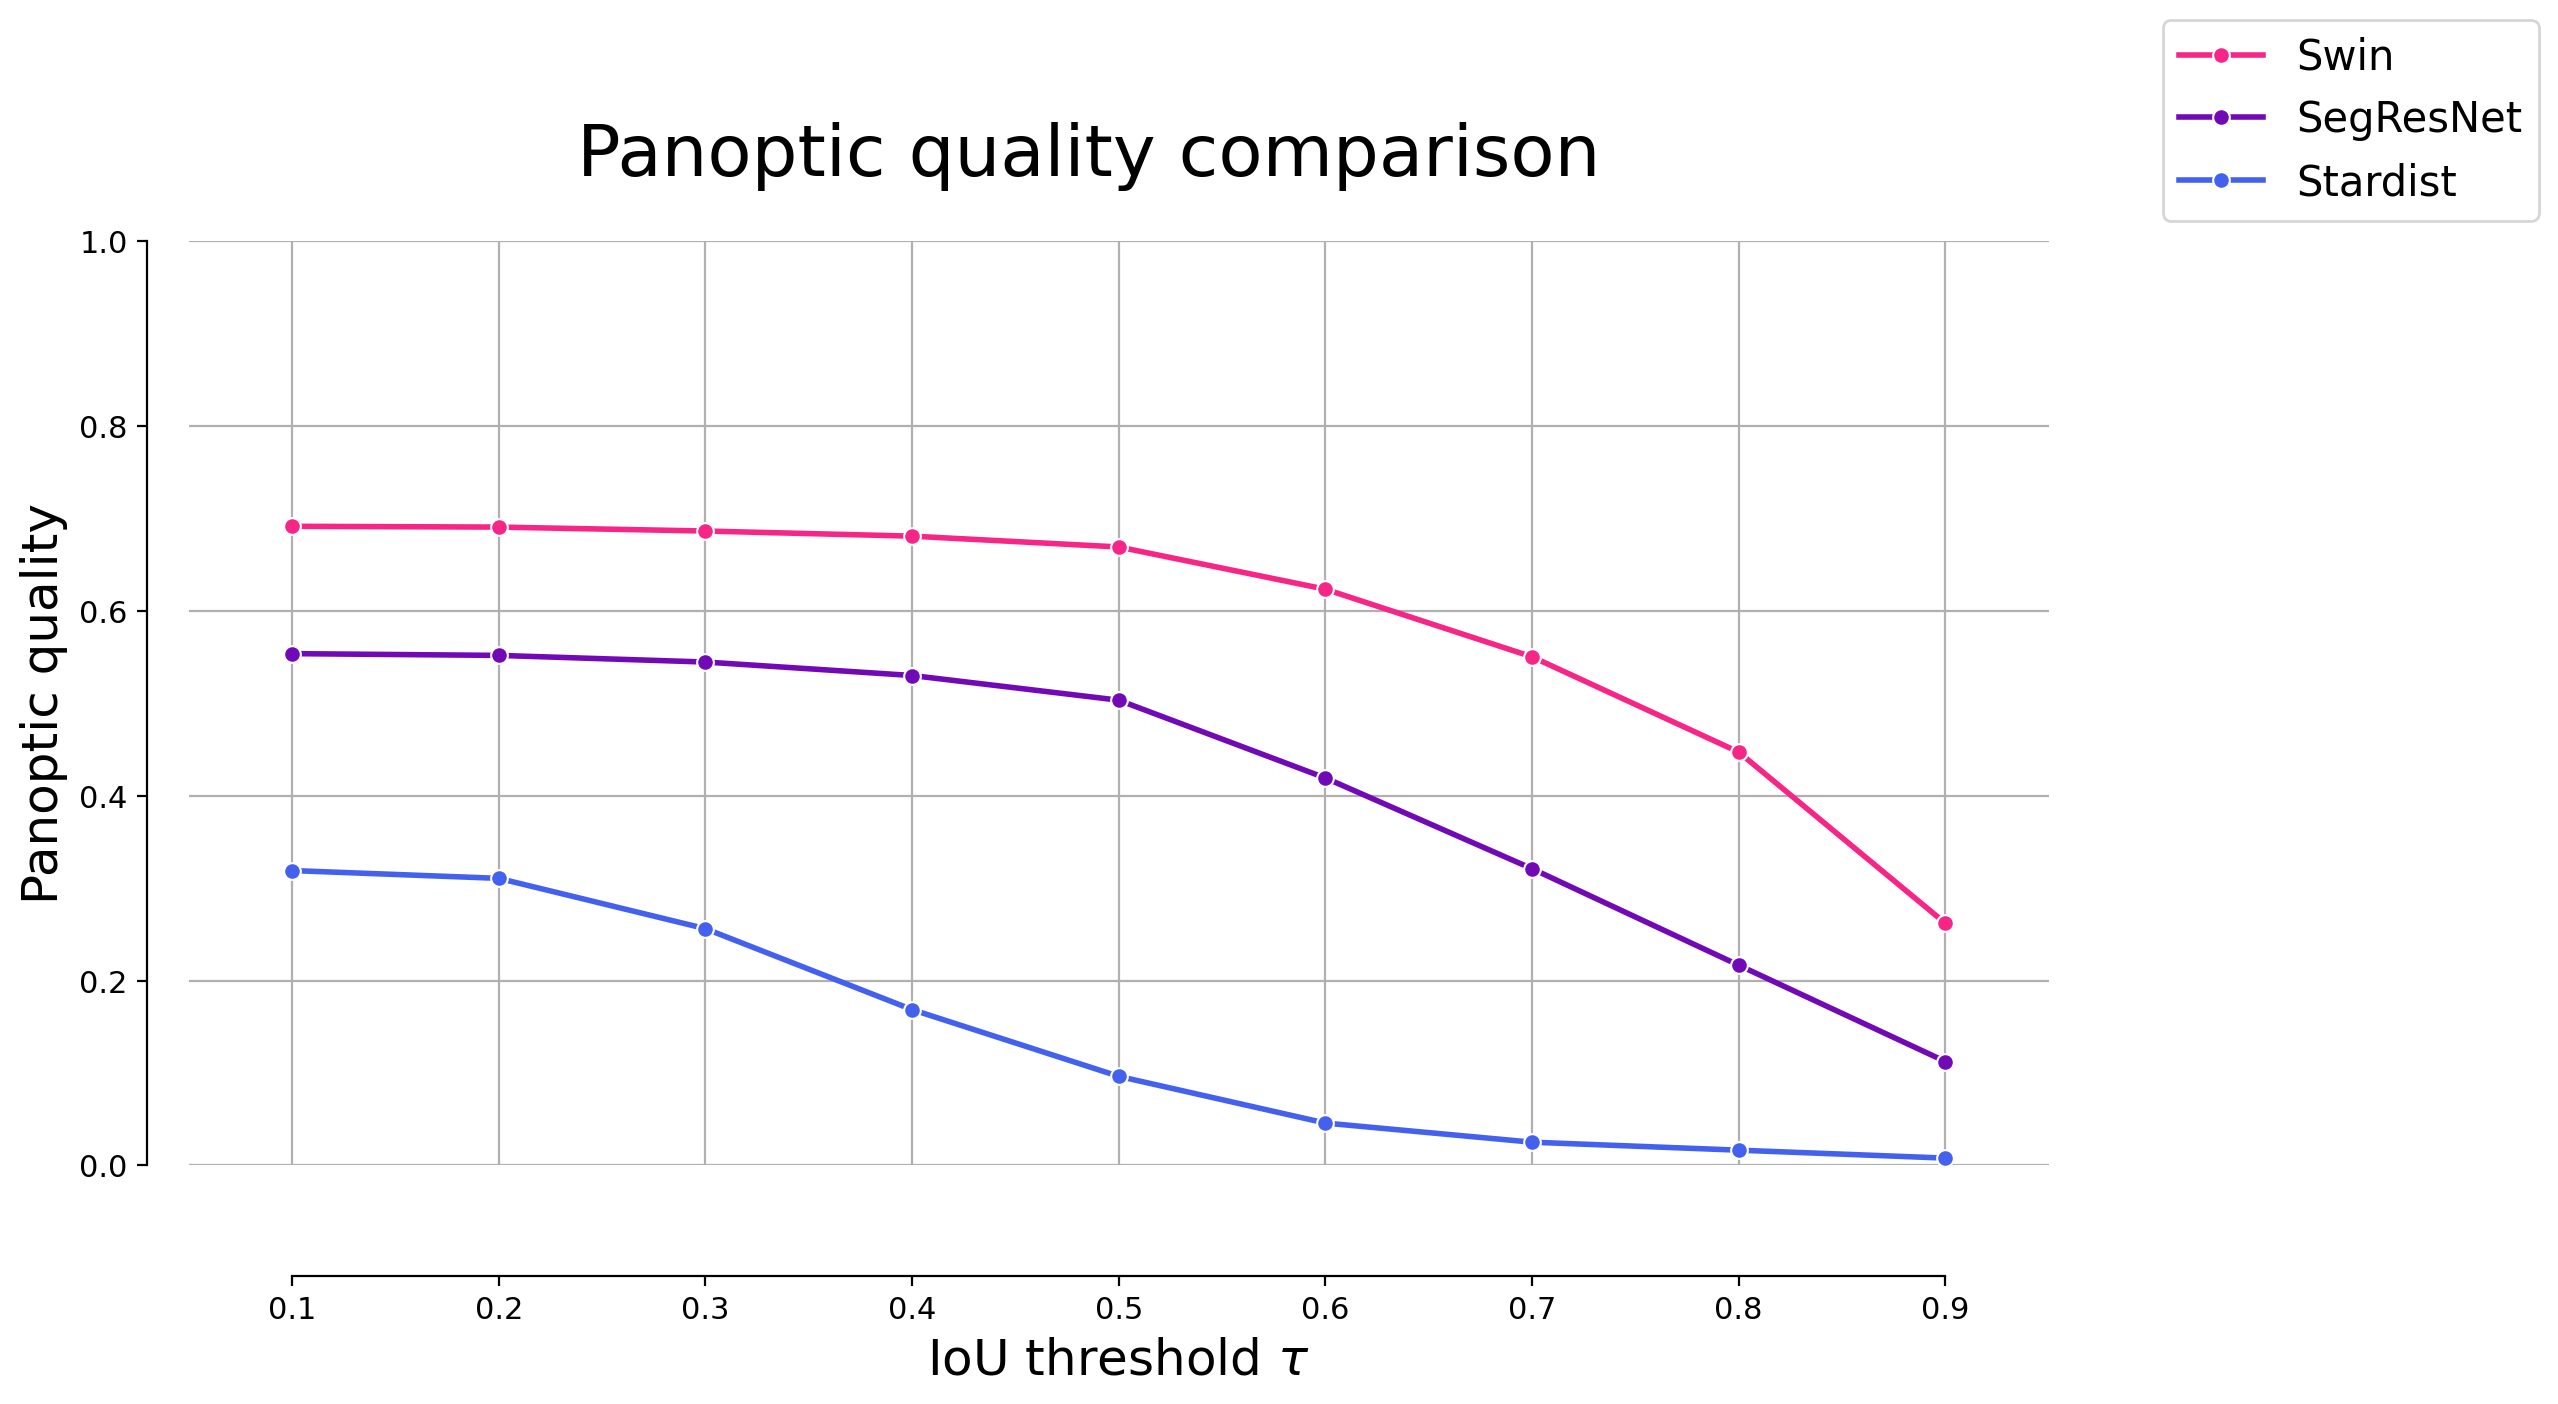

In [24]:
plot_stat_comparison(taus, model_stats, names, stat="panoptic_quality")
if SAVE_PLOTS_AS_PNG:
    plt.savefig("panoptic_quality.png", dpi=DPI, format="png", bbox_inches='tight')
if SAVE_PLOTS_AS_SVG:
    plt.savefig("panoptic_quality.svg", format="svg")

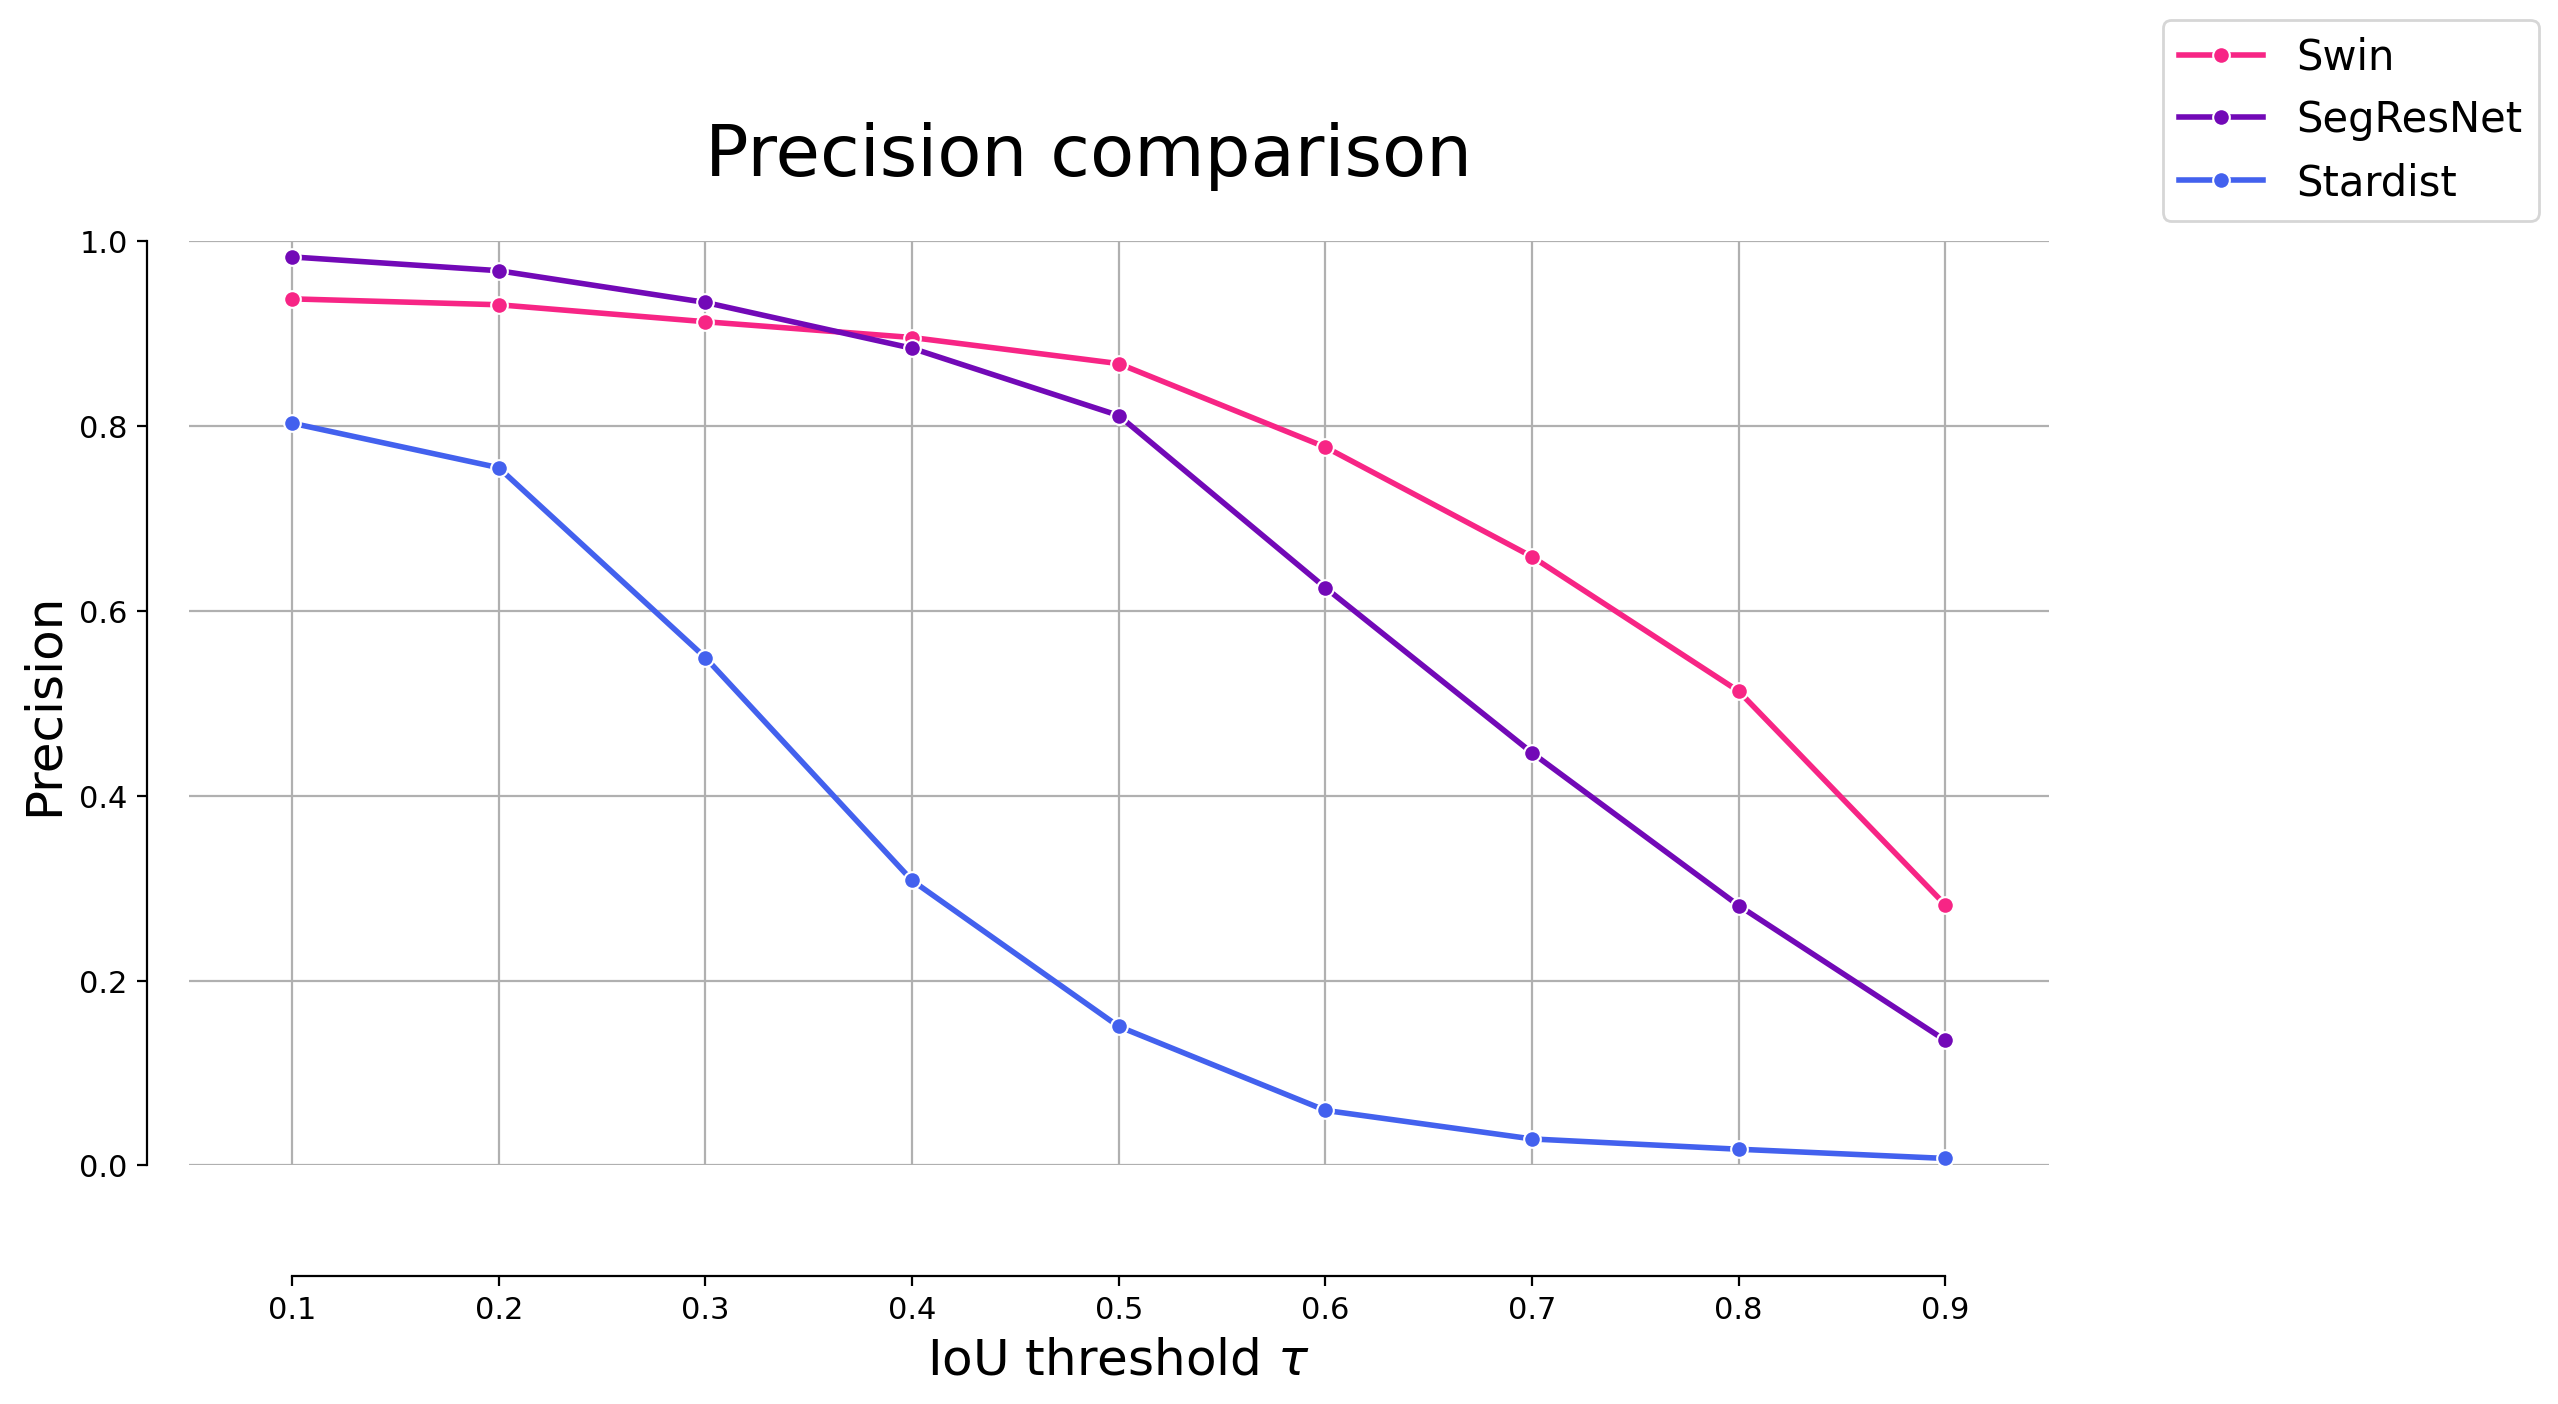

In [25]:
plot_stat_comparison(taus, model_stats, names, stat="precision")

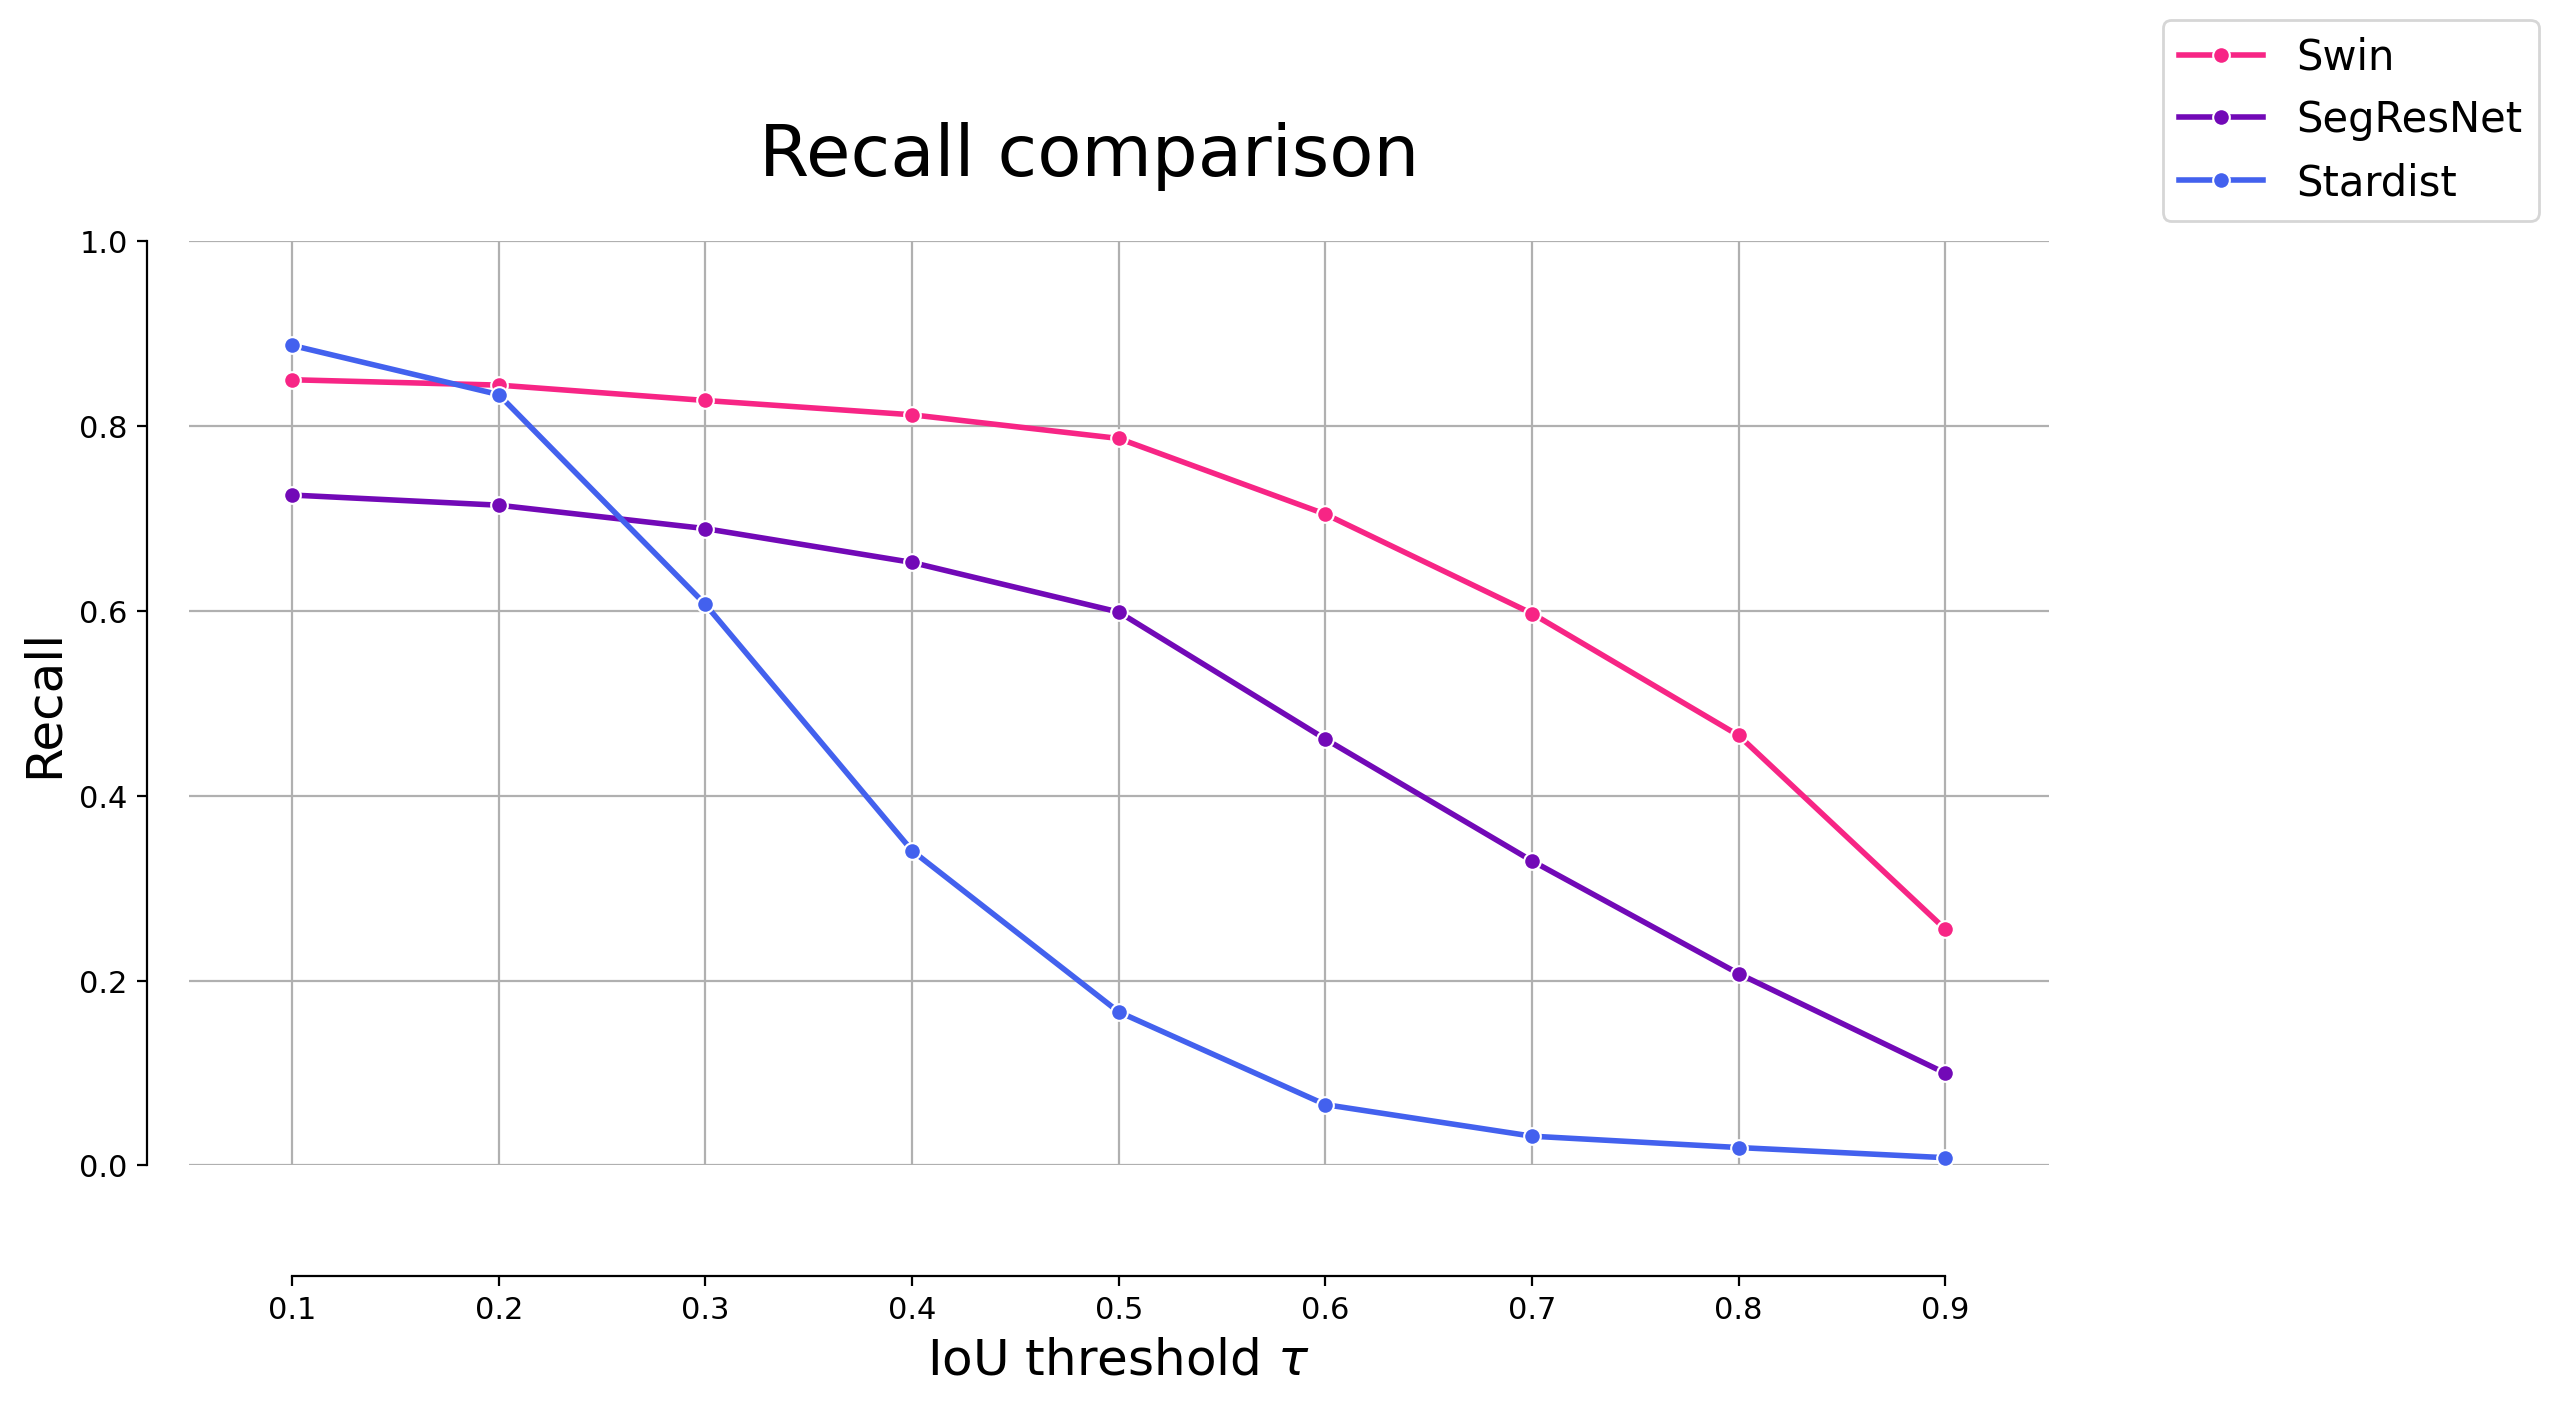

In [26]:
plot_stat_comparison(taus, model_stats, names, stat="recall")

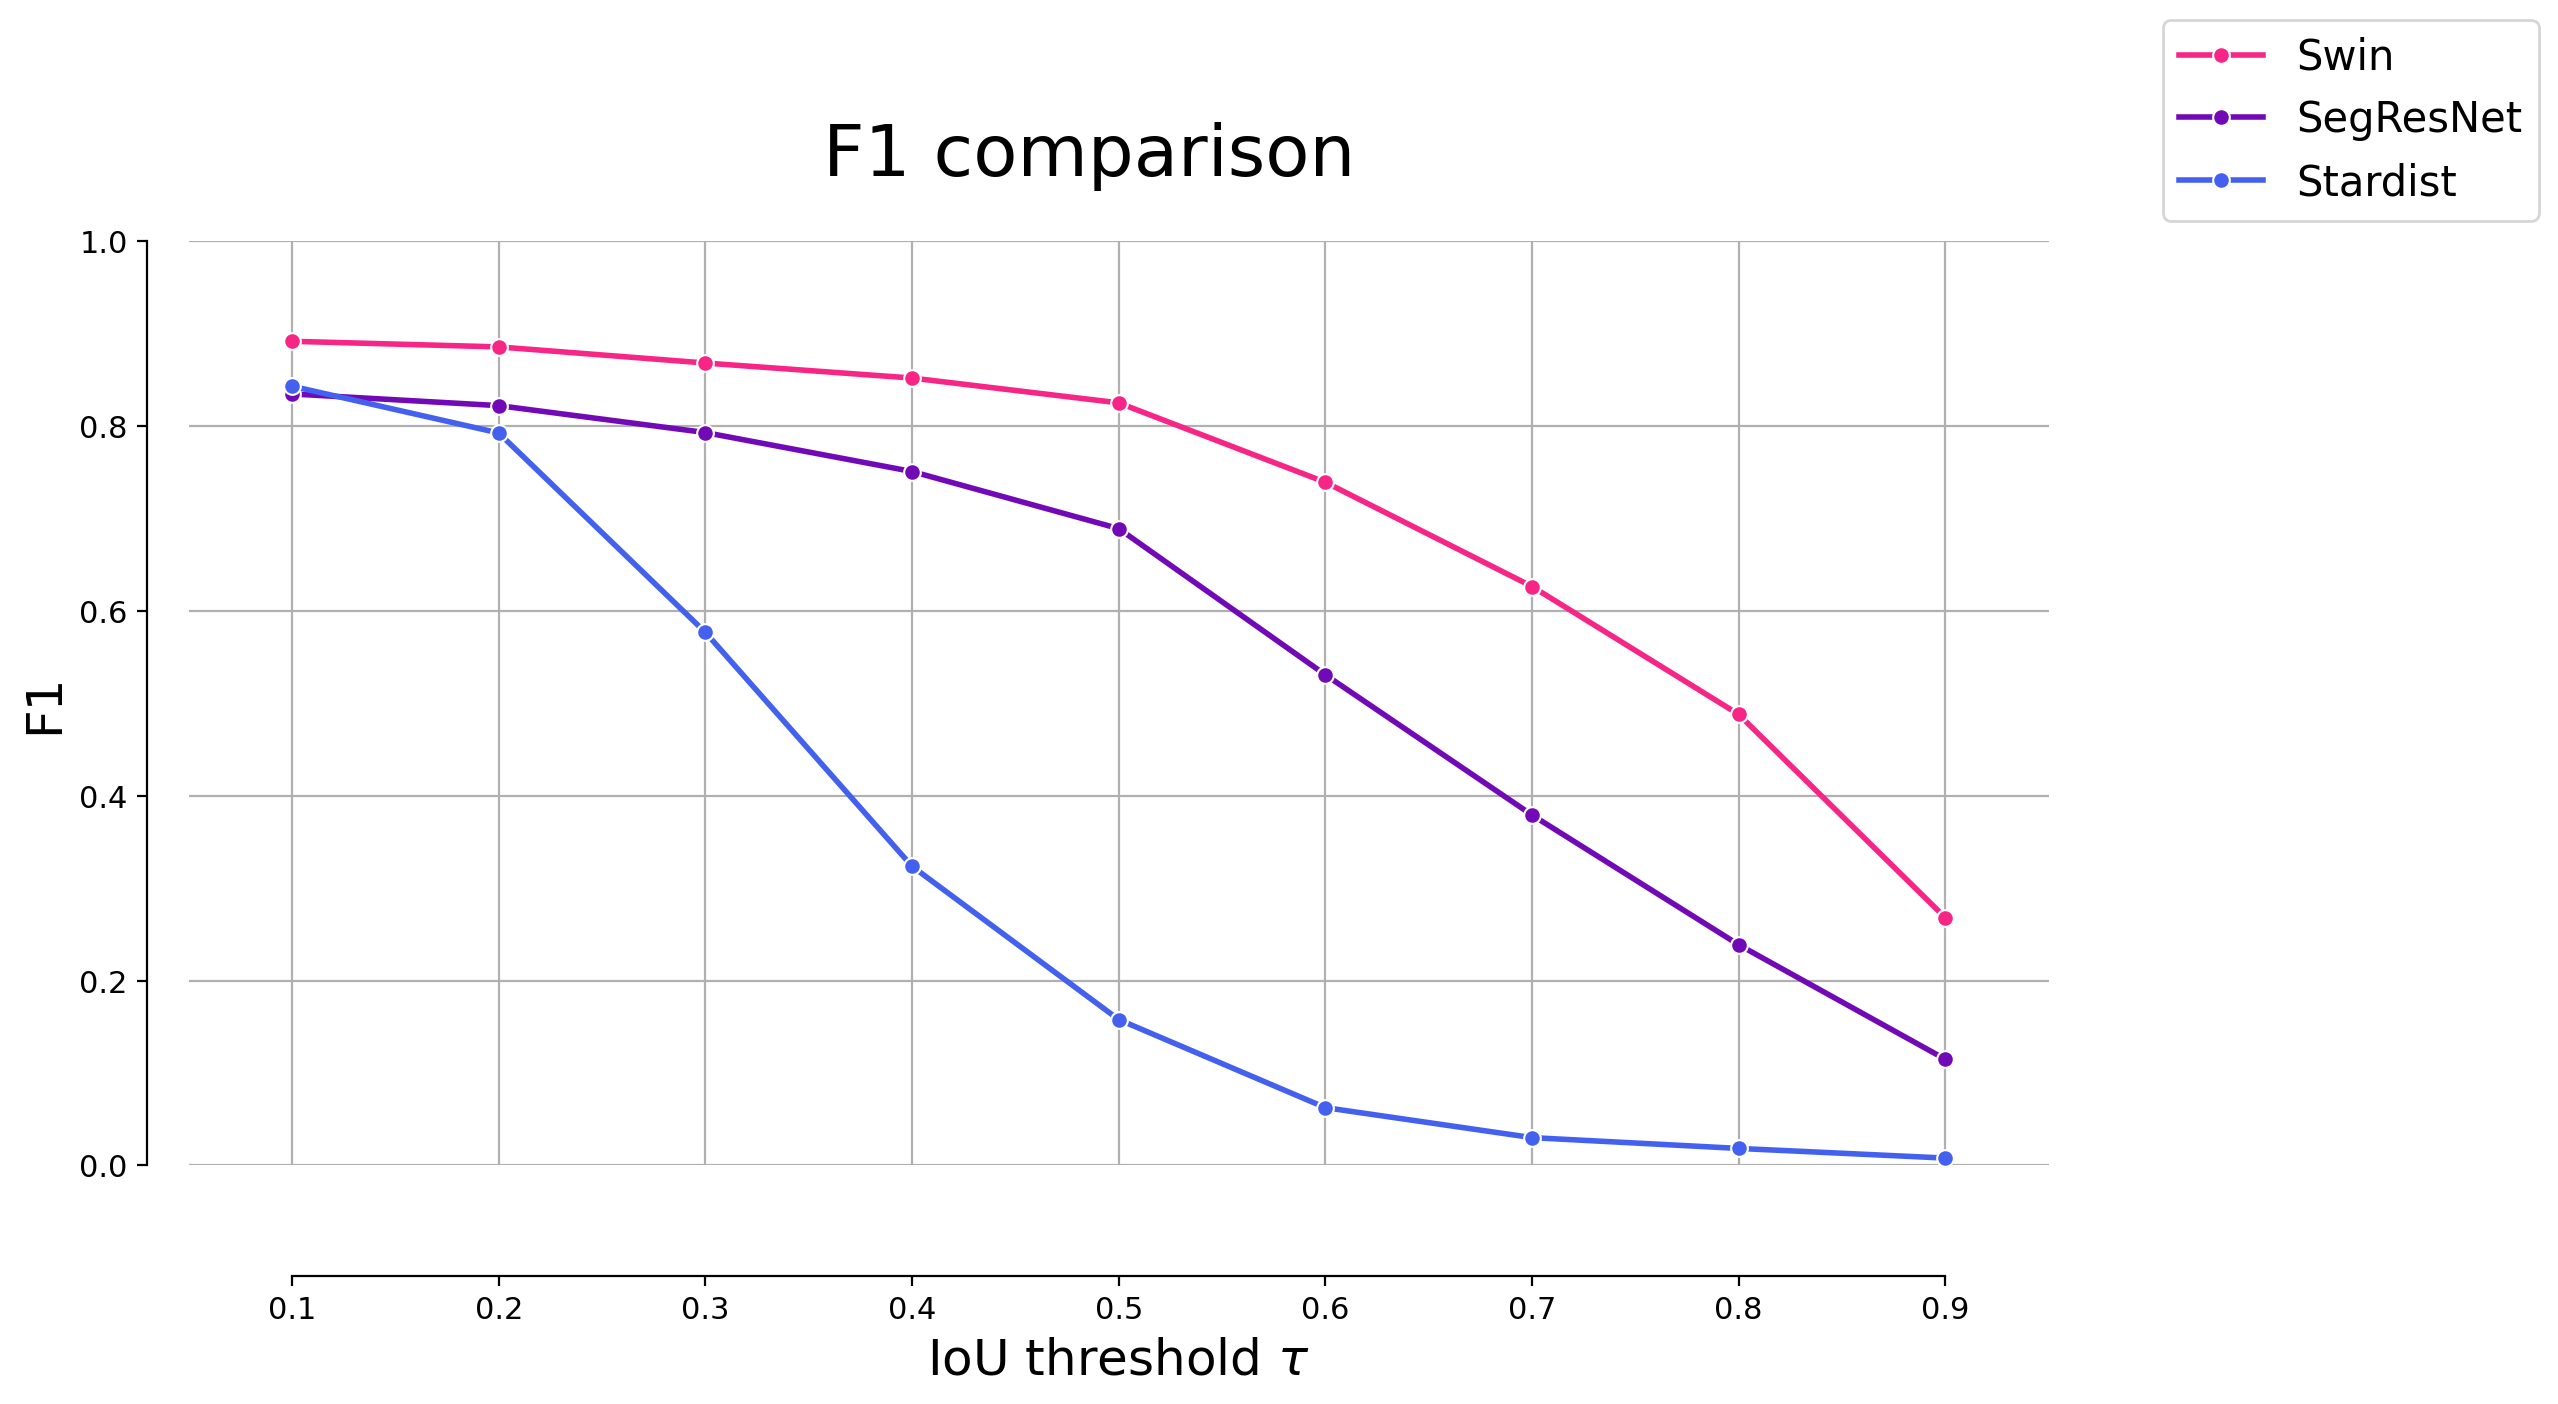

In [27]:
plot_stat_comparison(taus, model_stats, names, stat="f1")